In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

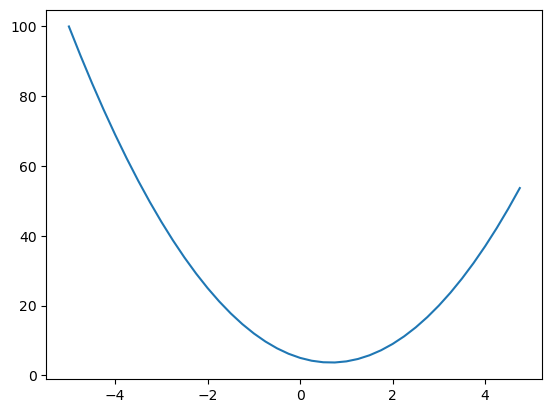

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
h = 0.00000001
x = -3.0
(f(x+h) - f(x))/h

-22.00000039920269

In [11]:
h = 0.00000001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
print('d1', d1)

a += h
d2 = a*b + c
print('d2', d2)

print('Slope: ', (d2-d1)/h)


d1 4.0
d2 3.99999997
Slope:  -2.999999981767587


In [274]:
class Value:
    # _children is a set of all the values that created this value
    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data  * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data**(other-1))) * out.grad
        out._backward = _backward

        return out
    
    # def __sub__(self, other):
    #     return Value(self.data - other.data, (self, other), '-')
    
    # def __div__(self, other):
    #     return Value(self.data // other.data)

    
    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # topological sorting order
        # topological sorting order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e' 

d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'




In [209]:
a = Value(12.0, label='a')
b = Value(-3.0, label='b')

a - b

Value(data=15.0)

In [78]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [79]:
d._op

'+'

In [275]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label= "{%s | data: %.4f | grad: %4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label= n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

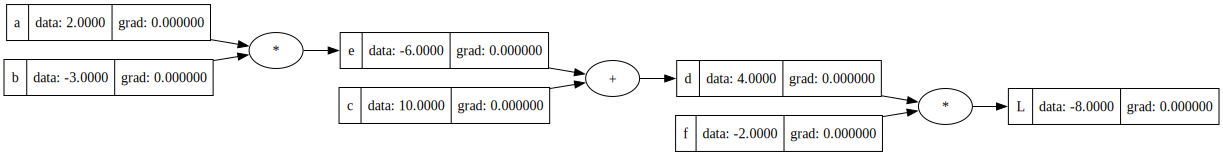

In [172]:
draw_dot(L)

# ***Inline gradient checker***

In [82]:
def foo():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f ; L.label = 'L'
    L2 = L.data

    return ((L2 - L1) / h)

foo()


-3.9999999999995595

In [83]:
L.grad = 1.0; d.grad = -2.0; f.grad = 4.0

c.grad = d.grad * 1.0; e.grad = d.grad * 1.0

a.grad = e.grad * b.data; b.grad = e.grad * a.data

In [102]:

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b; e.label = 'e'
d =  c + e ; d.label = 'd'
L = d * f; L.label = 'L'

print(L.data)

2.326527999999995


In [210]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1.w1'
x2w2 = x2 * w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1.w1 + x2.w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()


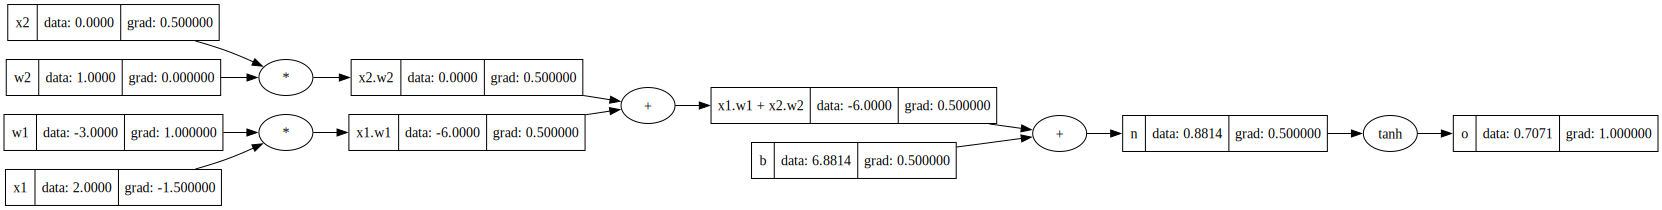

In [211]:
draw_dot(o)


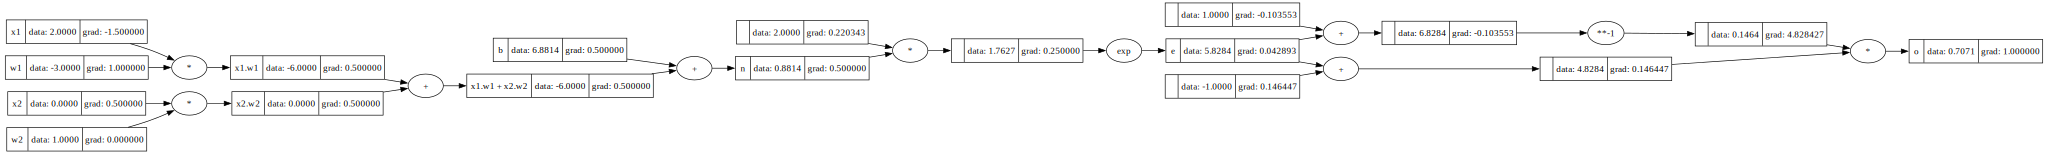

In [213]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1.w1'
x2w2 = x2 * w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1.w1 + x2.w2'
n = x1w1x2w2 + b; n.label = 'n'


# _________

e = ( 2 * n).exp() ; e.label = 'e'
o = ( e - 1) / ( e + 1) ; o.label = 'o'

o.backward()

draw_dot(o)

In [121]:
o.grad = 1.0
n.grad = o.grad * (1 - o.data**2) # d/dn tanh(n) = 1 - tanh(n)^2S

x1w1x2w2.grad = n.grad * 1.0
b.grad = n.grad * 1.0

x2w2.grad = x1w1.grad = x1w1x2w2.grad * 1.0


x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [148]:
o.grad = 1.0 # output gradient was intialized to 0.0 that's why we need to set it to 1.0


In [150]:
o._backward()

In [152]:
n._backward()

In [154]:
b._backward()

In [155]:
x1w1x2w2._backward()

In [157]:
x1w1._backward()
x2w2._backward()

In [163]:
o.grad = 1.0

In [164]:
# topological sorting order

topo = []

visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735869999997),
 Value(data=0.7071067811767758)]

In [165]:
for node in reversed(topo):
    if node._backward:
        node._backward()

In [176]:
o.backward()

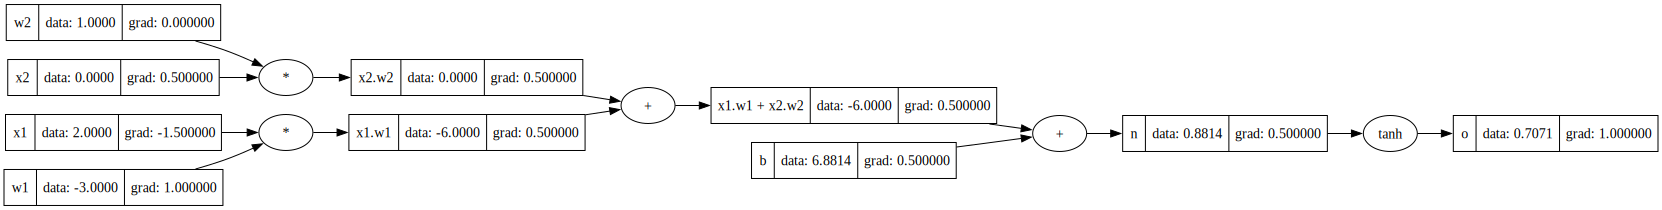

In [177]:
draw_dot(o)

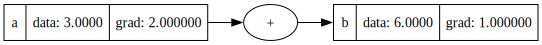

In [186]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

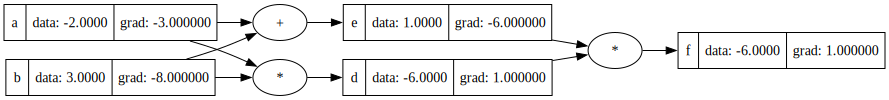

In [188]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')   

d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

In [312]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        



In [313]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4659336847865854)

In [314]:
len(n.parameters())

41

In [315]:
xs =  [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] 

# ***Forward Pass***

In [316]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.022894386105193)

In [317]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=6.022894386105193)

# ***Backward Pass***

In [318]:
loss.backward()

In [319]:
n.layers[0].neurons[0].w[0].grad

-0.7594618345926345

In [320]:
n.layers[0].neurons[0].w[0].data

-0.22007685781394715

# ***Update***

In [321]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [322]:
n.layers[0].neurons[0].w[0].data


-0.2124822394680208

In [339]:
# Gradient Descent
for step in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # zero-ing the gradients
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(f'Step {step+1}: {loss.data}')

Step 1: 0.003901117309301805
Step 2: 0.003880065855391083
Step 3: 0.0038592346846823824
Step 4: 0.0038386203955420592
Step 5: 0.003818219655577143
Step 6: 0.00379802919988992
Step 7: 0.0037780458293844663
Step 8: 0.0037582664091240277
Step 9: 0.003738687866737126
Step 10: 0.003719307190870849
Step 11: 0.003700121429689622
Step 12: 0.0036811276894180246
Step 13: 0.0036623231329259835
Step 14: 0.003643704978355181
Step 15: 0.0036252704977848835
Step 16: 0.003607017015936457
Step 17: 0.003588941908914546
Step 18: 0.0035710426029844948
Step 19: 0.003553316573383987
Step 20: 0.003535761343168694


In [338]:
ypred

[Value(data=0.9785601219506627),
 Value(data=-0.9659172633191232),
 Value(data=-0.9650531533884973),
 Value(data=0.9671395508160233)]

In [341]:
import scalarflow as sf

graph = sf.Graph()

print(graph)
with graph:
    x = sf.Variable(2.0, name='x')
    y = sf.Variable(4.0, name='y')

    x_squared = sf.Pow(x, 2)
    y_squared = sf.Pow(y, 2)

    xy_sum = sf.Add(x_squared, y_squared)

    func = sf.Pow(xy_sum, .5) # (Square root)

graph.gen_dot("sample.dot")

In [ ]:
graph.gen_dot("sample.dot")
